# Filtro pasabajos pasivo de segundo orden
<img src="./logo_UTN.svg" align="right" width="150" /> 

#### Por Mariano Llamedo Soria

### Resumen 
En este documento se presenta un ejemplo de **análisis numérico y circuital** para un filtro pasabajo simple de segundo orden. También se aprovecha el mismo circuito para ejemplificar respecto a las funciones para el análisis de la respuesta en frecuencia:

* [analyze_sys](https://pytc2.readthedocs.io/en/latest/autoapi/pytc2/sistemas_lineales/index.html#pytc2.sistemas_lineales.analyze_sys)
* [bodePlot](https://pytc2.readthedocs.io/en/latest/autoapi/pytc2/sistemas_lineales/index.html#pytc2.sistemas_lineales.bodePlot)
* [pzmap](https://pytc2.readthedocs.io/en/latest/autoapi/pytc2/sistemas_lineales/index.html#pytc2.sistemas_lineales.pzmap)
* [pretty_print_bicuad_omegayq](https://pytc2.readthedocs.io/en/latest/autoapi/pytc2/sistemas_lineales/index.html#pytc2.sistemas_lineales.pretty_print_bicuad_omegayq)

y las funciones para el dibujo de redes:
* [dibujar_elemento_derivacion](https://pytc2.readthedocs.io/en/latest/autoapi/pytc2/dibujar/index.html#pytc2.dibujar.dibujar_elemento_derivacion)
* [dibujar_puerto_entrada](https://pytc2.readthedocs.io/en/latest/autoapi/pytc2/dibujar/index.html#pytc2.dibujar.dibujar_puerto_entrada)
* [dibujar_espacio_derivacion](https://pytc2.readthedocs.io/en/latest/autoapi/pytc2/dibujar/index.html#pytc2.dibujar.dibujar_espacio_derivacion)
* [dibujar_elemento_serie](https://pytc2.readthedocs.io/en/latest/autoapi/pytc2/dibujar/index.html#pytc2.dibujar.dibujar_elemento_serie)
* [dibujar_puerto_salida](https://pytc2.readthedocs.io/en/latest/autoapi/pytc2/dibujar/index.html#pytc2.dibujar.dibujar_puerto_salida)


### Introducción

Comencemos con un ejemplo simple: un pasabajos de 2do orden pasivo como seguramente habrás visto en TC1:

![lpf_pasivo.png](lpf_pasivo.png)

es decir, la transferencia de tensión del circuito definida de la forma

\begin{equation}
H(s) = \frac{V_2}{V_1} = \frac{R(s)}{E(s)} = \frac{\frac{1}{LC}}{s^2 + s. \frac{1}{RC} + \frac{1}{LC}}
\end{equation}

se comporta como filtro pasabajos de 2do orden.

Entonces se entiende como **sección de segundo orden** (SOS por sus siglas en inglés) a un sistema lineal cuya transferencia $H(s)$ está definida por un cociente de polinomios, $E$ y $R$ en este caso, y al menos el denominador $E$ sea  de **segundo orden**. Para el caso concreto de un filtro pasabajo como el que se analiza, la función transferencia está definida por un polinomio denominador de segundo orden, y un numerador definido por una constante, es decir de orden 0. Para los polinomios de segundo orden se adoptará

* que sean *mónicos*, es decir el coeficiente de mayor orden valga 1.
* y los demás coeficientes se definirán en función de los parámetros $\omega_0$ y $Q$,

que se explican a continuación. Sea un polinomio 

$$ P(s) = a.s^2 + b.s + c, $$

se prefiere presentarlo como 

$$ P(s) = a.( s^2 + \frac{b}{a}.s + \frac{c}{a}) $$

ó ya parametrizado 

$$ P(s) = a.( s^2 +  \frac{\omega_0}{Q} . s + \omega_0^2) $$

 donde $\omega_0^2 = \frac{c}{a}$ y $Q = \sqrt{\frac{a.c}{b^2}}$. Esta parametrización tiene gran utilidad dado que $\omega_0$ es la pulsación natural de oscilación del circuito resonante, y $Q$ es el valor que tiene la transferencia H(s) para $s = j\omega_0$. Como $Q$ *por lo general* es mayor a $\frac{\sqrt{2}}{2}$, también se interpreta a $Q$ como el realce del filtro, en el contexto de un filtro pasabajos (o pasa-altos).

Las SOS son de gran utilidad, dado que junto con las funciones transferencia de primer orden permiten implementar sistemas de orden arbitrariamente grande. Es decir que un sistema de orden arbitrario puede representarse como una factorización (o cascada) de tantos SOS como corresponda y, eventualmente, si el orden fuera impar, de un sistema de primer orden. Volviendo a las SOS's tenemos que la transferencia desnormalizada $H_d(s)$ será

$$ H_d(s) = \frac{k.\omega_0^2}{s^2+s\frac{\omega_0}{Q}+\omega_0^2}. $$

 Luego adoptando como norma de frecuencia $\omega_0$, es decir haciendo $H(s) = H_d(s)\Big\vert_{s = s.\omega_0}
 $ obtenemos la versión normalizada en frecuencia

$$ H(s) = \frac{k}{s^2+s\frac{1}{Q}+1} $$

quedando como único parámetro $Q$, dado que ahora $\omega_0 = 1$. Para quien lea esta explicación y le interese el tema, podría analizar qué valores de L y C aseguran que el filtro pasabajo pasivo tenga una transferencia normalizada


Hecha esta introducción teórica se realizan los gráficos de la respuesta en frecuencia de módulo y fase para $\omega_0 = 1$ y $Q = \frac{\sqrt{2}}{2}$, junto con el diagrama de polos y ceros. Éstos análisis reciben el nombre de *simulación numérica* de la respuesta en frecuencia de circuitos, o simplemente de ahora en adelante **simulación numérica**.

La simulación numérica consiste en simular el comportamiento de las expresiones matemáticas que modelan el comportamiento de un circuito, utilizando las capacidades de cálculo que brindan los módulos **Numpy** y **SciPy**. 

En el caso de este ejemplo, nos centraremos en analizar el comportamiento de la función *módulo*, *fase* y *retardo* de $H(s)$.

Todas las simulaciones comienzan con la inicialización y configuración de módulos numéricos y gráficos.

In [1]:
# Módulos externos

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

# módulo de SciPy
from scipy import signal as sig

# Esta parte de código la agregamos SOLO en los notebooks para fijar el estilo de los gráficos.
fig_sz_x = 13
fig_sz_y = 7
fig_dpi = 80 # dpi
fig_font_size = 13

mpl.rcParams['figure.figsize'] = (fig_sz_x, fig_sz_y)
mpl.rcParams['figure.dpi'] = fig_dpi
plt.rcParams.update({'font.size':fig_font_size})

Ahora importamos las funciones de **PyTC2**

In [2]:

from pytc2.sistemas_lineales import analyze_sys, bodePlot, pzmap, pretty_print_bicuad_omegayq
from pytc2.general import print_latex, a_equal_b_latex_s


Luego se procede a la simulación propiamente dicha

In [3]:
# Comienzo de la simulación

Q = np.sqrt(2)/2
w0 = 1

# Cargamos la funcion transferencia como vectores de sus coeficientes.

num = np.array([ w0**2 ])
den = np.array([ 1., w0 / Q, w0**2 ])

H1 = sig.TransferFunction( num, den )

# mostramos la transferencia construida
display(H1)

TransferFunctionContinuous(
array([1.]),
array([1.        , 1.41421356, 1.        ]),
dt: None
)

Como se puede observar, luego de cargar el objeto *TransferFunction*, no es fácil volver a identificar los parámetros $\omega_0 = 1$ y $Q = \frac{\sqrt{2}}{2}$ que lo originaron. Para ello se utilizará una función creada para tal fin de poder manifestar dicha parametrización:

\begin{equation}
H_d(s) = \frac{1 . \omega_0^2}{s^2+s\frac{\omega_0}{Q}+\omega_0^2}.
\end{equation}


In [4]:
pretty_print_bicuad_omegayq(num,den)

# o un poco mejor, presentarlo como una ecuación:
print_latex(a_equal_b_latex_s('H_d(s)', pretty_print_bicuad_omegayq(num, den, displaystr=False)))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

De esta manera la comparación visual se ve facilitada. Continuando con el análisis realizamos la simulación numérica de $H(s)$ propiamente

(2, <Axes: xlabel='$\\sigma$', ylabel='j$\\omega$'>)

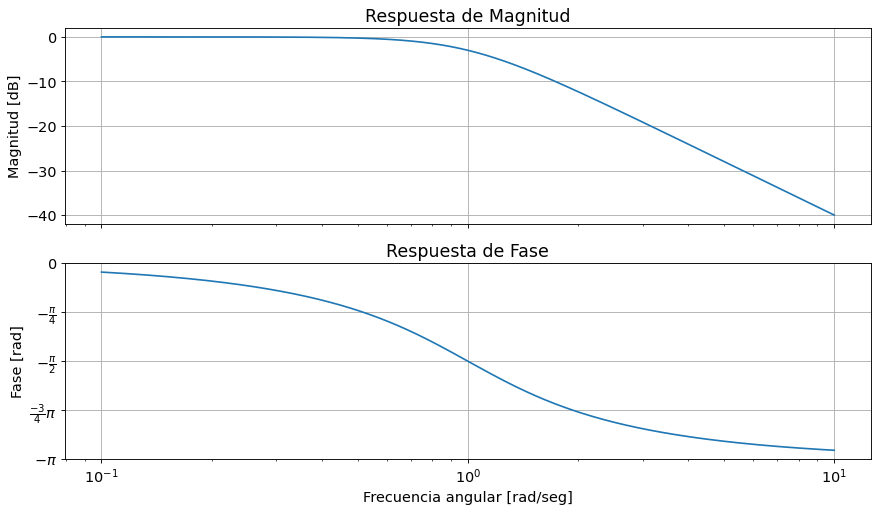

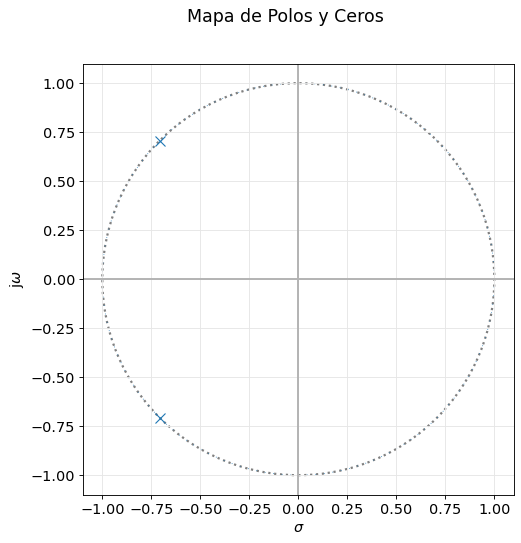

In [5]:
_, axes_hdl = bodePlot(H1)

plt.sca(axes_hdl[0])

pzmap(H1)

# Otra forma de analizar el sistema H1, con una función
# de más alto nivel. Podés probarlo si te interesa.
# analyze_sys(H1, sys_name='mi ejemplo')



otra manera de llegar al mismo resultado, con un poco más de detalle es a través de la función *analyze_sys*

[[1,
  array([<Axes: title={'center': 'Respuesta de Magnitud'}, ylabel='Magnitud [dB]'>,
         <Axes: title={'center': 'Respuesta de Fase'}, xlabel='Frecuencia angular [rad/seg]', ylabel='Fase [rad]'>],
        dtype=object)],
 [2, <Axes: xlabel='$\\sigma$', ylabel='j$\\omega$'>],
 [3, []],
 [4,
  <Axes: title={'center': 'Retardo de grupo'}, xlabel='Frecuencia angular [rad/seg]', ylabel='Retardo de grupo [seg]'>]]

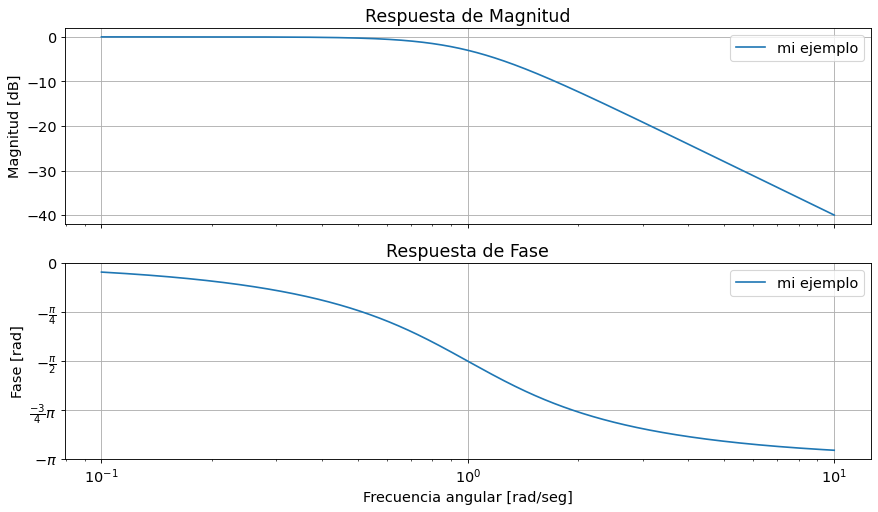

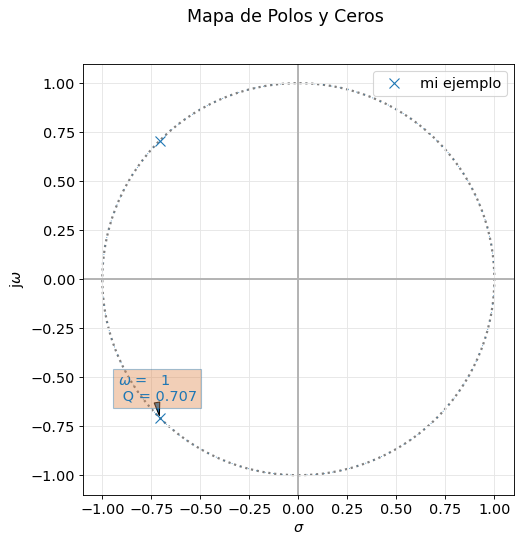

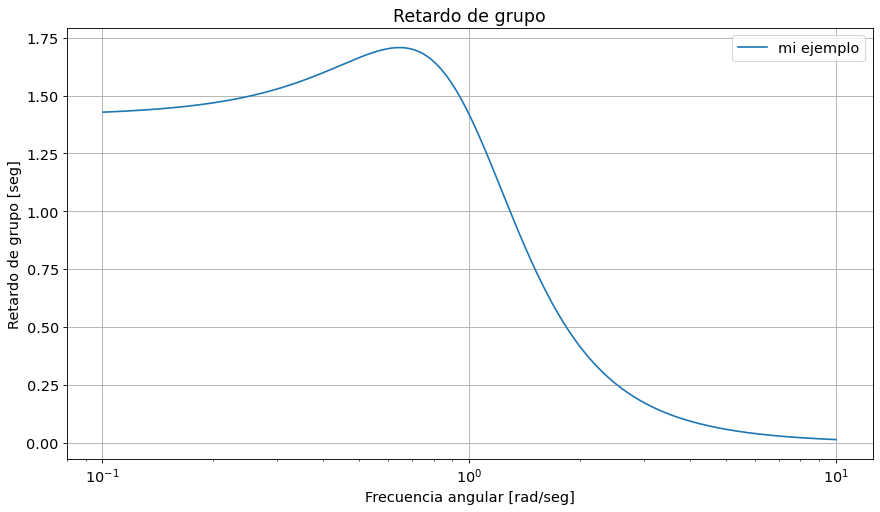

In [6]:
# Otra forma de analizar el sistema H1, con una función
# de más alto nivel. Podés probarlo si te interesa.

analyze_sys([H1], sys_name='mi ejemplo')



ciertamente *analyze_sys* extiende el análisis de la respuesta en frecuencia al calcular el *retardo de grupo*; como también incorpora información al *diagrama de polos y ceros*, acerca del  $\omega_0$ y $Q$ asociado a cada singularidad (polo o cero) o par de singularidades complejas conjugadas. Se sugiere el uso de *analyze_sys* y será la **función de referencia de ahora en adelante**.

### Simulación Circuital

La simulación circuital se realizará con el software gratuito [LTspice](https://www.analog.com/en/design-center/design-tools-and-calculators/ltspice-simulator.html). Para ello hay que dibujar el siguiente circuito:

![SOS_pasabajo_simple_circ.png](SOS_pasabajo_simple_circ.png)

Ejecutar el análisis de *AC sweep* configurado como se observa en la directiva *AC* visible en el circuito, e indicar que calcule la transferencia $V_2/V_1$

![SOS_pasabajo_simple_resp_frec.png](SOS_pasabajo_simple_resp_frec.png)

Como se puede observar, los resultados de la simulación circuital **coinciden** con la numérica. Recordar que en *LTspice* la respuesta en frecuencia es respecto a la frecuencia $f$, medida en (Hz), y no a la pulsación angular $\omega$ medida en radianes por segundo. Su relación es $\omega = 2.\pi. f$, y en consecuencia 1 r/s se corresponde con $1/(2\pi)$ Hz. 

Esto es evidencia suficiente para proceder a la siguiente instancia de diseño, que consiste en realizar un prototipo circuital, analizar las limitaciones prácticas de la implementación. Proceder al eventual rediseño, simulación y finalmente continuar con el diseño final y fabricación del circuito final.

## Apéndice

### Dibujo de circuitos

Finalmente se presenta una alternativa para el dibujo de circuitos eléctricos a partir de la propia librería **pyTC2**, que actúa como intérprete del módulo [schemdraw](https://schemdraw.readthedocs.io/en/latest/). La idea es dibujar la red de izquierda a derecha secuencialmente desde el generador $V_i$ hasta el puerto de salida $V_o$:

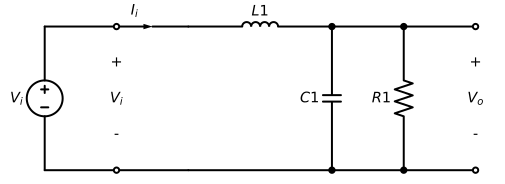

In [7]:
from schemdraw import Drawing
from pytc2.dibujar import dibujar_espacio_derivacion, dibujar_elemento_serie, dibujar_elemento_derivacion, dibujar_puerto_salida, dibujar_puerto_entrada
from pytc2.general import to_latex

d = Drawing(unit=4)
d = dibujar_elemento_derivacion(d, "V",  with_nodes=False, sym_label="V_i")
d = dibujar_espacio_derivacion(d)
d = dibujar_puerto_entrada(d, voltage_lbl=('+', to_latex('V_i'), '-'), current_lbl=to_latex('I_i'))
d = dibujar_elemento_serie(d, "L", sym_label="L1")
d = dibujar_elemento_derivacion(d, "C", sym_label="C1")
d = dibujar_espacio_derivacion(d)
d = dibujar_elemento_derivacion(d, "R", sym_label="R1")
d = dibujar_puerto_salida(d, voltage_lbl=('+', to_latex('V_o'), '-'))
display(d)
